<a href="https://www.kaggle.com/code/candacevogel/celeba-dataset-candace-vogel?scriptVersionId=263222111" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CelebA Glasses Facial Characteristic Recognition

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.v2 as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets

from os import path
from PIL import Image

In [2]:
# Load data - create path to files

In [3]:
dataset_root = '/kaggle/input/celeba-dataset'
# root directory path
# input data from dataset

image_path = path.join(dataset_root, 'img_align_celeba/img_align_celeba')
# image_path contains the jpg files
attributes_path = path.join(dataset_root, 'list_attr_celeba.csv')
# file path for the csv file containing the attributes

# Read attributes CSV

In [4]:
df_attributes = pd.read_csv(attributes_path)
df_attributes.head() # display first few rows
# dataframe (df) is a type of table that panda library uses
# read csv file using pandas library ^
df_attributes.replace(-1, 0, inplace=True)
# converts negative -1 to 0 for normalizing data
df_attributes['Eyeglasses'].head()
# this output will print just the eyeglasses data

0    0
1    0
2    0
3    0
4    0
Name: Eyeglasses, dtype: int64

In [5]:
# Replace -1 with 0

In [6]:

df_attributes.replace(-1, 0, inplace=True)
# 1 is true / represents wearing glasses
# 0 is false / represents not wearing glasses
# replaces every instance of -1 with 0
# now the data is all 0s and 1s
df_attributes['Eyeglasses'].head()
# prints just eyeglasses attributes column

0    0
1    0
2    0
3    0
4    0
Name: Eyeglasses, dtype: int64

# How many people are wearing glasses?

In [7]:
df_attributes['Eyeglasses'].value_counts()
# prints number of people wearing glasses in dataset
# and the number of people not wearing glasses in dataset

Eyeglasses
0    189406
1     13193
Name: count, dtype: int64

# Balance dataset

In [8]:
glasses_df = df_attributes [ df_attributes ['Eyeglasses'] == 1]
no_glasses_df = df_attributes [ df_attributes['Eyeglasses'] == 0]
# filtering attributes for glasses and no glasses
# 0 == falsey, 1 == truthy

len(glasses_df), len(no_glasses_df)
# prints how many people are wearing glasses vs no glasses
glasses_count = len(glasses_df)
# prints how many people have glasses 
no_glasses_same_size = no_glasses_df.sample(glasses_count)
# sample is pandas method (pick rows at random)
len(no_glasses_same_size)
# prints how many people don't wear glasses in dataset
df_glasses_training = pd.concat ( [glasses_df, no_glasses_same_size], axis=0 )
# concatenate variables onto row axis
# axis=0 stacks tables vertically
# df_glasses_training is our balanced dataset
# the data is normalized so there is an equal number of images for glasses vs no glasses
# len(df_glasses_training)

df_glasses = df_glasses_training[['image_id','Eyeglasses']].sample(10)
#display 10 rows at random
df_glasses.sample(10)
#only prints attributes we care about - normalized eyeglasses data

,image_id,Eyeglasses
159688,159689.jpg,0
75597,075598.jpg,1
176375,176376.jpg,1
57823,057824.jpg,0
174527,174528.jpg,0
105900,105901.jpg,1
128260,128261.jpg,0
98383,098384.jpg,0
142214,142215.jpg,1
45127,045128.jpg,0


# Create a Dataset Class

In [9]:
class CelebDataset(Dataset):
    # initializing our dataset with variables
    def __init__(self, images_path, attributes_dataframe, img_transform=None, attr_transform=None):
        self.images_path = images_path # initializing images
        self.attributes_dataframe = attributes_dataframe # storing dataframe
        self.img_transform = img_transform    #image transform function
        self.attr_transform = attr_transform    # attribute transform function
        self.image_filename = attributes_dataframe['image_id'].tolist()  # list of images in dataset

    # method to access items by index
    def __getitem__(self, index):
        # return the image and its label that are in position (index) in the dataset
        image_filename = self.image_filename[index]
        # .join will create the format of our image pathways
        image_path = path.join(self.images_path, image_filename)
        img = Image.open(image_path).convert('L')
        # convert is PIL function - grayscale images require less storage

        attributes = self.attributes_dataframe.iloc[index]
        glasses = attributes.Eyeglasses.astype('int')
        # need to process data before we send to NN 
        # if img_transform is provided...
        
        if self.img_transform:
            img = self.img_transform(img)
            # call img_transform function

        if self.attr_transform:
            glasses = self.attr_transform(glasses)
            # not used, butmay be useful in another situation

        return img, glasses
# returns the length of attributes_dataframe
    def __len__(self):
        return len(self.attributes_dataframe)
        

        

# Define image transformations

In [10]:
# how we will resize our image
image_size = 128

image_transform = transforms.Compose([
    transforms.Resize(image_size), #resizes image on the shorter side to 128px
    transforms.CenterCrop( [image_size, image_size] ), #crops center of image into 128px square
    ToTensor(), #converts jpg to PyTorch Tensor (binary values)
])
# creating our dataset
# we condensed all necessary data into 2 variables
dataset = CelebDataset(image_path, df_glasses, image_transform)

# Divide dataset into training and test data

In [11]:
# 80% training 
# 20% testing
train_dataset, test_dataset = random_split(dataset, (0.8, 0.2) )

# Create dataloaders for train and test datasets

In [12]:
batch_size = 32
# need to batch data to train and test in smaller chunks, data is too big
# batch for speed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# DataLoader function for sending information to our NN

# Visualize example images

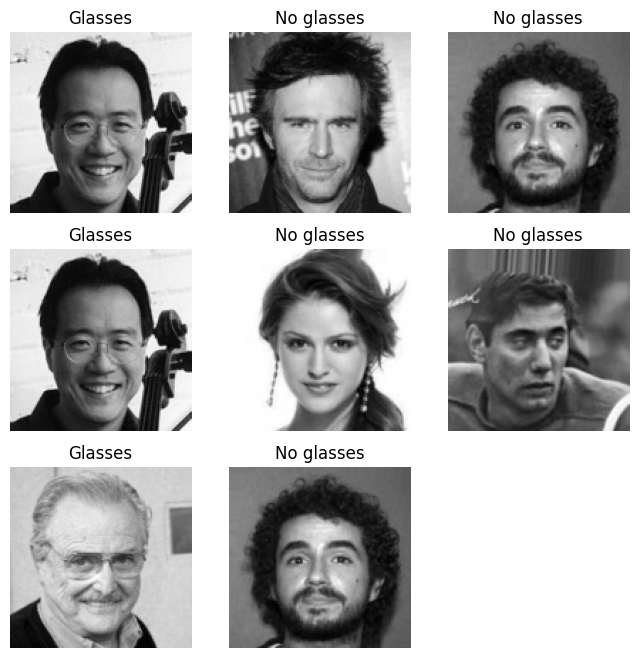

In [13]:
import matplotlib.pyplot as plt
# create map plot of data
figure = plt.figure(figsize=(8,8)) # our canvas to display data
cols = 3
rows = 3
for i in range(1, cols * rows):
    # loops over dataset
    # .randint picks random data from dataset
    sample_index = torch.randint(len(train_dataset), size=(1, )).item()
    img, label = train_dataset[sample_index]
    figure.add_subplot(rows, cols, i)
    # display titles in plots
    plt.title('Glasses' if label == 1 else 'No glasses')
    plt.axis('off')
    # display grayscale image
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()
# initialize function

# Create a device

In [14]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f'Using {device} device')
# detecting hardware to use for trianing using if/else statement
# identifies accelerator type for processing dataset

Using cuda device


# Create neural network!

In [15]:
class NeuralNetwork(nn.Module):
    # initialize all network layers
    def __init__(self):
        super().__init__() # parent class
        self.flatten = nn.Flatten() # flatten tensor to 1D
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            # flattened to 512 neurons
            nn.ReLU(), # activiation function
            nn.Linear(512, 512), # hidden layer
            nn.ReLU(),
            nn.Linear(512, 2) # output layer
        )
    def forward(self, x):
        # x is one training data item aka one image
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # logits = values from each output neuron

model = NeuralNetwork().to(device)
# creates instance of NN model and .to() chooses appropriate hardware

model #print model for user

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

# Define backwards pass

In [16]:
loss_function = nn.CrossEntropyLoss()
# classification function - how wrong is our model predictions?
# CrossEntropyLoss is for categorical predictions 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# optimizer will improve our dataset predictions...
# by updating weights and gradients

# Define training function

In [17]:
def train(dataloader, model, loss_function, optimizer):
    # len() prints size of dataset
    size = len(dataloader.dataset)
    model.train() # training mode for NN model
    # working with batched data
    for batch_num, (image_batch, label_batch) in enumerate(dataloader):
        img, labels = image_batch.to(device), label_batch.to(device)
        # hardware function
        predictions = model(img) # forward pass
        loss = loss_function(predictions, labels) # how wrong is our model?
        loss.backward() # calculate the changes that will be made to weights and biases
        optimizer.step()  # apply changes
        optimizer.zero_grad() # resets optimizer in between batches
        # if batch number is divisble by 100..
        if batch_num % 100 == 0: # for every 100th batch...
            loss = loss.item() # loss value 
            current = (batch_num + 1) * len(img) # calculate batched samples
            print(f'Loss: {loss} [ { current } / {size} ]') #prints data for user

# Define test function

In [18]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # model in test mode
    test_loss = 0 # by how much is our data wrong?
    test_correct = 0 # track accuracy rate

    with torch.no_grad(): # don't change the model
        # loop over batches in test data
        for image_batch, label_batch in dataloader:
            img, labels = image_batch.to(device), label_batch.to(device) #hardware function
            predictions = model(img)  #forward pass
            test_loss = loss_function(predictions, labels).item() #how wrong is our data?
            test_correct += (predictions.argmax(1) == labels).type(torch.float).sum().item()
            # count predictions ^
    test_loss /= num_batches
    # calculate the average of loss from all batches
    test_correct /= size #calculate accuracy rate

    print(f'Test results, Accuracy: {test_correct * 100}% Average Loss: {test_loss}')
    
            

# Training the model

In [19]:
epoch = 5 # initialize epoch variable, number of training epocs

# loop over training epoch
for t in range(epoch):
    print(f'EPOCH {t+1} **********')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function)
    

EPOCH 1 **********
Loss: 0.6917737722396851 [ 8 / 8 ]
Test results, Accuracy: 50.0% Average Loss: 0.6882091760635376
EPOCH 2 **********
Loss: 0.6878541707992554 [ 8 / 8 ]
Test results, Accuracy: 50.0% Average Loss: 0.6866637468338013
EPOCH 3 **********
Loss: 0.6841080188751221 [ 8 / 8 ]
Test results, Accuracy: 50.0% Average Loss: 0.6851435899734497
EPOCH 4 **********
Loss: 0.6805196404457092 [ 8 / 8 ]
Test results, Accuracy: 50.0% Average Loss: 0.6837745904922485
EPOCH 5 **********
Loss: 0.6770381927490234 [ 8 / 8 ]
Test results, Accuracy: 50.0% Average Loss: 0.6825160980224609


# Test with more images

In [20]:
def predict_glasses(image_file_path):
    # this function will predict if an image shows glasses
    print(image_file_path)
    test_image = Image.open(image_file_path).convert('L')
    # convert img to grayscale
    mystery_image = image_transform(test_image)
    mystery_image = mystery_image.to(device)
    # set model to evaluate data
    model.eval()
    with torch.no_grad(): #disable gradients for yes/no
        model_output = model(mystery_image) # logits
    print(model_output)
    label = torch.argmax(model_output).item() # 0 or 1?
    # 0 means no glasses and 1 means glasses
    label_text = 'Glasses' if label == 1 else 'No glasses'
    print('Prediction: ' + label_text)

# image_1 = '/kaggle/input/real-images/face_1_with_glasses.png'
# predict_glasses(image_1)

import os
# get and sort image files and construct file paths for reading files
for image_file in sorted(os.listdir('/kaggle/input/real-images/')):
    image_file_path = path.join('/kaggle/input/real-images/', image_file)
    predict_glasses(image_file_path)
    



/kaggle/input/real-images/face_1_with_glasses.png
tensor([[ 0.0077, -0.0562]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_2_with_glasses.png
tensor([[ 0.0342, -0.1242]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_3_no_glasses.png
tensor([[ 0.0396, -0.0974]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_4_no_glasses.png
tensor([[ 0.0336, -0.0756]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_5_no_glasses.png
tensor([[ 0.0016, -0.0494]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_6_with_glasses.png
tensor([[ 0.0186, -0.1146]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_7_with_glasses.png
tensor([[ 0.0526, -0.0783]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_8_no_glasses.png
tensor([[ 0.0167, -0.0459]], device='cuda:0')
Prediction: No glasses
/kaggle/input/real-images/face_9_with_glasses.png
tensor